## Baseline code

- target: count컬럼

In [1]:
import pandas as pd

In [2]:
train = pd.read_csv("/kaggle/input/bike-sharing-demand/train.csv")
test = pd.read_csv("/kaggle/input/bike-sharing-demand/test.csv")

## EDA

In [3]:
# 데이터 크기
train.shape, test.shape

((10886, 12), (6493, 9))

In [4]:
# 데이터 샘플
train.head(2)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40


In [5]:
# 데이터 샘플
test.head(2)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000


- casual, registered의 합이 count인 것을 확인할 수 있음 (test에는 없으므로 제거)

In [6]:
# 결측값 확인
train.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

In [7]:
# 결측값 확인
test.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
dtype: int64

<AxesSubplot:>

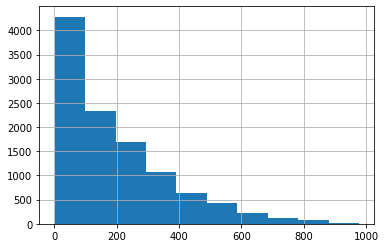

In [8]:
train['count'].hist()

## 전처리

In [9]:
# datetime

train['datetime'] = pd.to_datetime(train['datetime'])
test['datetime'] = pd.to_datetime(test['datetime'])

train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.day

test['year'] = test['datetime'].dt.year
test['month'] = test['datetime'].dt.month
test['day'] = test['datetime'].dt.day

train = train.drop('datetime', axis=1)
test = test.drop('datetime', axis=1)

In [10]:
# test에는 없는 컬럼 삭제
train = train.drop(['casual', 'registered'], axis=1)
train.head(1)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day
0,1,0,0,1,9.84,14.395,81,0.0,16,2011,1,1


In [11]:
# target 별도 저장
target = train.pop('count')
target

0         16
1         40
2         32
3         13
4          1
        ... 
10881    336
10882    241
10883    168
10884    129
10885     88
Name: count, Length: 10886, dtype: int64

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train, target, test_size=0.2, random_state=2023)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((8708, 11), (2178, 11), (8708,), (2178,))

## 선형회귀 모델

In [13]:
# 평가
from sklearn.metrics import r2_score

In [14]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)
pred = lr.predict(X_val)
r2_score(y_val, pred)

0.30780476926281297

## 랜덤포레스트

In [15]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
pred = rf.predict(X_val)
r2_score(y_val, pred)

0.438516899626206

## XGBoost 모델

In [16]:
from xgboost import XGBRegressor
xgb = XGBRegressor()
xgb.fit(X_train, y_train)
pred = xgb.predict(X_val)
r2_score(y_val, pred)

0.40839958233431084

In [17]:
# 하이퍼파라미터 
from xgboost import XGBRegressor
xgb = XGBRegressor(n_estimators=500, learning_rate=0.01, max_depth=9)
xgb.fit(X_train, y_train)
pred = xgb.predict(X_val)
r2_score(y_val, pred)

0.4473182182516243

## test 데이터 예측

In [18]:
# 예측
pred = xgb.predict(test)
pred

array([ 86.14312,  67.58316,  67.58316, ..., 146.57967, 109.61407,
       178.52168], dtype=float32)

In [19]:
# csv 파일 생성
test = pd.read_csv("/kaggle/input/bike-sharing-demand/test.csv")

submit = pd.DataFrame({
    'datetime': test['datetime'],
    'count': pred
})
submit.to_csv("submission.csv", index=False)

In [20]:
# 점검
print(pd.read_csv("submission.csv"))
print(submit.shape, test.shape)

                 datetime      count
0     2011-01-20 00:00:00   86.14312
1     2011-01-20 01:00:00   67.58316
2     2011-01-20 02:00:00   67.58316
3     2011-01-20 03:00:00   79.79623
4     2011-01-20 04:00:00   79.79623
...                   ...        ...
6488  2012-12-31 19:00:00  148.04665
6489  2012-12-31 20:00:00  148.04665
6490  2012-12-31 21:00:00  146.57967
6491  2012-12-31 22:00:00  109.61407
6492  2012-12-31 23:00:00  178.52168

[6493 rows x 2 columns]
(6493, 2) (6493, 9)
